In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import time
import tracemalloc
import random
import math
from tabulate import tabulate
from queue import PriorityQueue
from math import exp
from itertools import count
from matplotlib import colors
from collections import deque
import heapq
from collections import deque

In [ ]:
class Problem:
    '''
    Abstract base class for problem formulation.
    It declares the expected methods to be used by a search algorithm.
    All the methods declared are just placeholders that throw errors if not overriden by child "concrete" classes!
    '''

    def __init__(self,init_state=None):
        self.init_state = None

    def actions(self, state):
        raise NotImplementedError

    def result(self, state, action):
        raise NotImplementedError

    def goal_test(self, state):
        raise NotImplementedError

    def step_cost(self, state, action):
        raise NotImplementedError

class Node:
    '''Node data structure for search space bookkeeping.'''

    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    @classmethod
    def root(cls, init_state):
        return cls(init_state, None, None, 0)

    @classmethod
    def child(cls, problem, parent, action):
        return cls(
            problem.result(parent.state, action),
            parent,
            action,
            parent.path_cost + problem.step_cost(parent.state, action))

    @classmethod
    def expand(self, problem):
        return [self.child(problem, action) for action in problem.actions(self.state)]

# DroneNavigationProblem class models the environment, initial/goal states, and actions
class DroneNavigationProblem(Problem):
    """
    Represents a 3D drone navigation problem within a defined grid.
    """
    def __init__(self, grid_size, initial_state, goal_state):
        self.grid_size = grid_size  # 3D grid (NxNxN)
        self.initial_state = initial_state  # Starting position of the drone
        self.goal_state = goal_state  # Goal position for the drone

    def get_initial_state(self):
        return self.initial_state

    def is_goal(self, state):
        return state == self.goal_state

    def get_actions(self, state):
        actions = []
        x, y, z = state
        if x > 0: actions.append("left")
        if x < self.grid_size[0] - 1: actions.append("right")
        if y > 0: actions.append("backward")
        if y < self.grid_size[1] - 1: actions.append("forward")
        if z > 0: actions.append("down")
        if z < self.grid_size[2] - 1: actions.append("up")
        return actions

    def transition(self, state, action):
        x, y, z = state
        if action == "left": return (x - 1, y, z)
        if action == "right": return (x + 1, y, z)
        if action == "backward": return (x, y - 1, z)
        if action == "forward": return (x, y + 1, z)
        if action == "down": return (x, y, z - 1)
        if action == "up": return (x, y, z + 1)

    def get_cost(self, state, action):
        return 1

    def heuristic(self, state, goal_state):
        x1, y1, z1 = state
        x2, y2, z2 = goal_state
        return abs(x1 - x2) + abs(y1 - y2) + abs(z1 - z2)

    def result(self, state, action):
        return self.transition(state, action)

    def step_cost(self, state, action):
        return 1

def reconstruct_path(parent_map, state):
    path = []
    while state is not None:
        path.append(state)
        state = parent_map[state]
    path.reverse()
    return path


def heuristic(state, goal):
    """Heuristic function based on Euclidean distance."""
    x1, y1, z1 = state
    x2, y2, z2 = goal
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# For Reconstruct Path
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, heuristic_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.heuristic_cost = heuristic_cost

    @classmethod
    def root(cls, init_state):
        return cls(init_state, None, None, 0, 0)

    @classmethod
    def child(cls, problem, parent, action):
        state = problem.result(parent.state, action)
        heuristic_cost = problem.heuristic(state, problem.goal_state)
        return cls(state, parent, action, parent.path_cost, heuristic_cost)

    # Define the comparison method for the priority queue
    def __lt__(self, other):
        return self.heuristic_cost < other.heuristic_cost

def hill_climbing(problem):
    """Hill Climbing search algorithm."""
    current_state = problem.get_initial_state()

    while True:
        neighbors = []
        for action in problem.get_actions(current_state):
            next_state = problem.transition(current_state, action)
            neighbors.append(next_state)

        # Choose the best neighbor based on heuristic
        best_neighbor = max(neighbors, key=lambda state: -problem.heuristic(state, problem.goal_state))

        if problem.heuristic(best_neighbor, problem.goal_state) >= problem.heuristic(current_state, problem.goal_state):
            break  # No better neighbor, so we stop

        current_state = best_neighbor

    return current_state

class Visualizer:
    def __init__(self, problem):
        self.problem = problem
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')

    def visualize_path(self, path):
        x_coords = [state[0] for state in path]
        y_coords = [state[1] for state in path]
        z_coords = [state[2] for state in path]

        self.ax.clear()
        self.ax.plot(x_coords, y_coords, z_coords, marker='o', linestyle='-', color='b', label='Path')
        self.ax.scatter(*self.problem.initial_state, color='green', label='Start', s=100)
        self.ax.scatter(*self.problem.goal_state, color='red', label='Goal', s=100)
        self.ax.set_xlim([0, self.problem.grid_size[0]])
        self.ax.set_ylim([0, self.problem.grid_size[1]])
        self.ax.set_zlim([0, self.problem.grid_size[2]])
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')
        self.ax.legend()
        plt.draw()
        plt.pause(0.1)

# Hill Climbing Algorithm with Output and Path Visualization
def hill_climbing(problem, max_iterations=100):
    current_state = problem.get_initial_state()
    path = [current_state]

    print(f"Initial State: {current_state}")

    for _ in range(max_iterations):
        neighbors = problem.get_actions(current_state)
        if not neighbors:
            return path

        # Evaluate the neighbors based on the heuristic
        next_state = None
        best_heuristic = float('inf')

        for action in neighbors:
            neighbor_state = problem.result(current_state, action)
            heuristic_cost = problem.heuristic(neighbor_state, problem.goal_state)
            if heuristic_cost < best_heuristic:
                best_heuristic = heuristic_cost
                next_state = neighbor_state

        # If no improvement, we've reached a local maximum, so return the current state
        if next_state == current_state:
            return path

        current_state = next_state
        path.append(current_state)

        print(f"Current State: {current_state} | Path: {path}")

    return path

# Measure performance
def analyza_hill_climbing(problem, max_iterations=100):
    start_time = time.time()
    tracemalloc.start()

    result = hill_climbing(problem, max_iterations=100)

    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    time_taken = end_time - start_time

    memory_used = current_memory / 10**6  # Convert to MB

    if result:
        completeness = "Complete: Solution found."
    else:
        completeness = "Incomplete: No solution found."

    print(f"Time taken: {time_taken:.4f} seconds")
    print(f"Memory used: {memory_used:.4f} MB")
    print(completeness)

Initial State: (9, 9, 9)
Current State: (8, 9, 9) | Path: [(9, 9, 9), (8, 9, 9)]
Current State: (7, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9)]
Current State: (6, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9)]
Current State: (5, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9)]
Current State: (4, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9)]
Current State: (3, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9)]
Current State: (2, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9)]
Current State: (1, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9), (1, 9, 9)]
Current State: (0, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9), (1, 9, 9), (0, 9, 9)]
Current State: (0, 8, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9

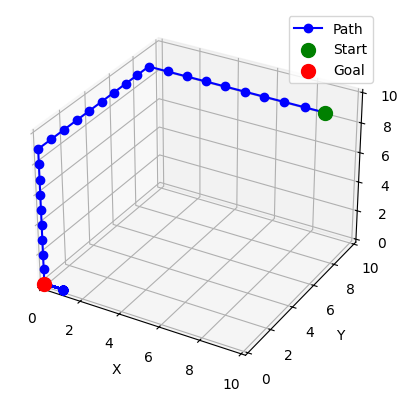

In [ ]:
problem = DroneNavigationProblem(grid_size=(10, 10, 10), initial_state=(9, 9, 9), goal_state=(0, 0, 0))

# Run Hill Climbing and visualize path
hill_climbing_solution = hill_climbing(problem)
if hill_climbing_solution:
    print("Hill Climbing Solution Found:", hill_climbing_solution)
    visualizer = Visualizer(problem)
    visualizer.visualize_path(hill_climbing_solution)
    plt.show()
else:
    print("Hill Climbing: No solution found.")


In [ ]:
# Example usage
problem = DroneNavigationProblem(grid_size=(10, 10, 10), initial_state=(9, 9, 9), goal_state=(0, 0, 0))
analyza_hill_climbing(problem, max_iterations=100)

Initial State: (9, 9, 9)
Current State: (8, 9, 9) | Path: [(9, 9, 9), (8, 9, 9)]
Current State: (7, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9)]
Current State: (6, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9)]
Current State: (5, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9)]
Current State: (4, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9)]
Current State: (3, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9)]
Current State: (2, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9)]
Current State: (1, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9), (1, 9, 9)]
Current State: (0, 9, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9), (5, 9, 9), (4, 9, 9), (3, 9, 9), (2, 9, 9), (1, 9, 9), (0, 9, 9)]
Current State: (0, 8, 9) | Path: [(9, 9, 9), (8, 9, 9), (7, 9, 9), (6, 9, 9